In [1]:
!pip install duckduckgo_search
!pip install fastai

from google.colab import drive
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import *
import time
drive.mount('/content/gdrive')

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [2]:
!cd 'gdrive/MyDrive/Colab Notebooks/'
path_sample_images = Path('gdrive/MyDrive/Colab Notebooks/sample_images')
if not path_sample_images.exists():
    path_sample_images.mkdir()

path_dataset = Path('gdrive/MyDrive/Colab Notebooks/datasets')
if not path_dataset.exists():
    path_dataset.mkdir()

path_models = Path('gdrive/MyDrive/Colab Notebooks/models')
if not path_models.exists():
    path_models.mkdir()

Searching for 'toyota supra'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


https://www.carscoops.com/wp-content/uploads/2019/11/toyota-supra-gr-heritage-la-live-pics-27.jpg


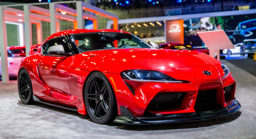

In [3]:
dest_sample = (f'{path_sample_images}/toyota_supra_example.jpg')
urls = search_images('toyota supra', max_images = 1)
print(urls[0])
# ...and then download a URL and take a look at it:

download_url(urls[0], dest_sample, show_progress = False)
im = Image.open(dest_sample)
im.to_thumb(256, 256)

In [6]:
car_models = 'toyota supra','nissan gtr','porshe 911', 'lamborghini countach', 'honda civic'
dest_dataset = Path(f'{path_dataset}/car_models')

if not dest_dataset.exists():
    dest_dataset.mkdir()
for car_model in car_models:
    dest = (dest_dataset/car_model)
    dest.mkdir(exist_ok=True)
    download_images(dest, urls=search_images(f'{car_model}', 100))
    time.sleep(10)  # Pause between searches to avoid over-loading server

Searching for 'toyota supra'
Searching for 'nissan gtr'
Searching for 'porshe 911'
Searching for 'lamborghini countach'
Searching for 'honda civic'


In [7]:
fns = get_image_files(dest_dataset)
failed = verify_images(fns)
print(f'Number of images with bad URL: {len(failed)}')
failed.map(Path.unlink);

Number of images with bad URL: 11


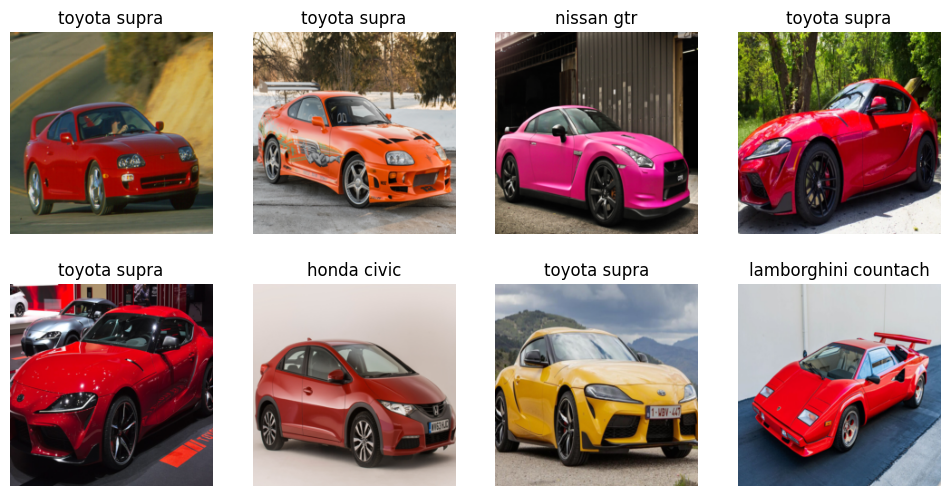

In [8]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

cars = cars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cars.dataloaders(dest_dataset)

dls.valid.show_batch(max_n=8, nrows=2)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.636361,2.717095,0.807692,00:31


epoch,train_loss,valid_loss,error_rate,time
0,1.881360,1.897720,0.641026,00:35
1,1.656449,1.284364,0.564103,00:32
2,1.484068,0.850815,0.371795,00:38
3,1.352158,0.613707,0.243590,00:39
4,1.194927,0.490902,0.192308,00:32
5,1.076363,0.412740,0.141026,00:32
6,0.966424,0.376338,0.141026,00:33
7,0.867870,0.354216,0.128205,00:31
8,0.799824,0.346660,0.115385,00:31
9,0.744962,0.353287,0.128205,00:42


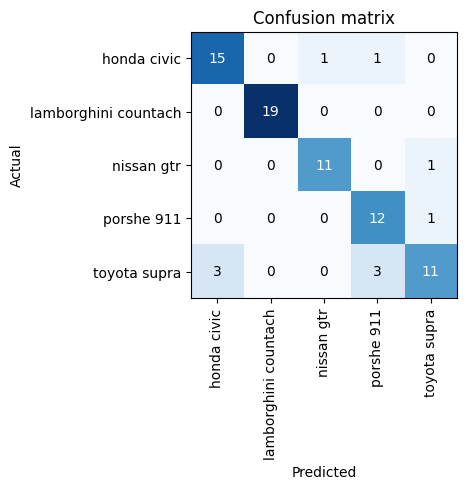

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [17]:
what_car,index,probs = learn.predict(PILImage.create(f'{path_sample_images}/toyota_supra_example.jpg'))
print(f"This is a: {what_car}.")
print(f"Probability it's a {what_car}: {probs[index.item()]:.4f}")
print(f"All Probabilities: {probs.tolist()}")

This is a: toyota supra.
Probability it's a toyota supra: 0.9985
All Probabilities: [0.0006248103454709053, 1.79954895429546e-05, 0.00015816280210856348, 0.0007095761247910559, 0.9984893798828125]


In [18]:
dest_model = (f'{path_models}/cars.pkl')
learn.export(dest_model)

In [19]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [21]:
!pip install gradio
import gradio as gr
gr.Interface(fn=predict, inputs=gr.inputs.Image(shape=(512, 512)), outputs=gr.outputs.Label(num_top_classes=5)).launch(share=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://88196c4b2ba63a95e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
